# Simulation and backtesting

Import packages and pickle files

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import timedelta, datetime
from scipy.stats import johnsonsu
import pulp

path = os.getcwdb().decode("utf-8")+"/data"

Change imported data depending on methodology used (DMLP or quantile LASSO)

In [2]:
#scaler_x, scaler_y_a1, scaler_y_a2, scaler_y_sp, X_scaled, y_a1_scaled, y_a2_scaled, y_sp_scaled, \
#           X_test_scaled, y_test_a1_scaled, y_test_a2_scaled, y_test_sp_scaled, fit_a1, fit_a2, fit_sp, auction1_predict, \
#           auction2_predict, system_price_predict = pickle.load(open(path+"/pickle_2_alt.pkl", "rb"))
scaler_x, X_scaled, y_a1, y_a2, y_sp, X_test_scaled, y_test_a1, y_test_a2, y_test_sp, feature_names, imp_order = pickle.load(open(path+"/pickle_1.pkl", "rb"))
auction1_predict, auction2_predict, system_price_predict = pickle.load(open(path+"/FF_predictions.pkl", "rb"))
#auction1_predict, auction2_predict, system_price_predict, _, _, _ = pickle.load(open(path+"/pickle_2_2.pkl", "rb"))


In [3]:
auction1_predict=np.array(auction1_predict)
auction2_predict=np.array(auction2_predict)
system_price_predict=np.array(system_price_predict)

Calculation of pinball score

In [4]:
from sklearn.metrics import mean_pinball_loss

def pinball_score(y, params):
    loss_total = 0
    for i in range(1,100):
        y_pred = np.zeros(len(y))
        for j in range(len(y)):
            y_pred[j] = johnsonsu.ppf(i/100, params[j,0], params[j,1], params[j,2], params[j,3])
        loss = mean_pinball_loss(y, y_pred, alpha=i/100)
        print(loss)
        loss_total+=loss
    return loss_total

In [5]:
# pinball_score(y_test_sp[2:], system_price_predict)

In [8]:
sample_size=720*1

y_a1_inter=np.concatenate([y_a1[-sample_size:], y_test_a1], axis=0)
y_a2_inter=np.concatenate([y_a2[-sample_size:], y_test_a2], axis=0)
y_sp_inter=np.concatenate([y_sp[-sample_size:], y_test_sp], axis=0)
y_a1_inter=y_a1_inter.reshape(len(y_a1_inter), -1)
y_a2_inter=y_a2_inter.reshape(len(y_a1_inter), -1)
y_sp_inter=y_sp_inter.reshape(len(y_a1_inter), -1)
#y_a1_inter=np.concatenate([y_a1_scaled[-sample_size:,:], y_test_a1_scaled], axis=0)
#y_a2_inter=np.concatenate([y_a2_scaled[-sample_size:,:], y_test_a2_scaled], axis=0)
#y_sp_inter=np.concatenate([y_sp_scaled[-sample_size:,:], y_test_sp_scaled], axis=0)


In [9]:
cov_mat=[]
corr_mat=[]

x_input = np.concatenate([y_a1_inter,y_a2_inter,y_sp_inter], axis=1)

def z_calc(x,params):
    gamma=params[0,:]
    delta=params[1,:]
    xi=params[2,:]
    lambd=params[3,:]
    return gamma+delta*np.arcsinh((x-xi)/lambd)

for i in range(len(auction1_predict)):

    fit_mat=np.transpose(np.vstack([auction1_predict[i,:],auction2_predict[i,:],system_price_predict[i,:]]))

    z = z_calc(x_input[i:i+sample_size,:], fit_mat)

    cov_mat.append(np.cov(np.transpose(z)))
    corr_mat.append(np.corrcoef(np.transpose(z)))

corr_mat = np.array(corr_mat)    

In [10]:
#corr_mat[1050:1150,2,0]

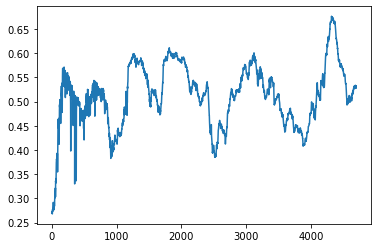

In [11]:
plt.plot(corr_mat[:,2,0])

Scenario generation

In [12]:
from scipy.stats import multivariate_normal

def x_calc(z,params):
    gamma=params[0]
    delta=params[1]
    xi=params[2]
    lambd=params[3]
    return xi+lambd*np.sinh((z-gamma)/delta)

In [13]:
random.seed(1)

simulation_a1=np.array([])
simulation_a2=np.array([])
simulation_sp=np.array([])
for i in range(len(auction1_predict)):
    r=multivariate_normal.rvs((0,0,0), cov_mat[i], size=sample_size)

    simulation_a1 = np.concatenate([simulation_a1, x_calc(r[:,0], auction1_predict[i,:])])
    simulation_a2 = np.concatenate([simulation_a2, x_calc(r[:,1], auction2_predict[i,:])])
    simulation_sp = np.concatenate([simulation_sp, x_calc(r[:,2], system_price_predict[i,:])])
    

In [14]:
simulation_a1=simulation_a1.reshape(len(auction1_predict), -1)
simulation_a2=simulation_a2.reshape(len(auction2_predict), -1)
simulation_sp=simulation_sp.reshape(len(system_price_predict), -1)

## Predicted distribution evaluation

In [17]:
y_test_a1=y_test_a1[-len(auction1_predict):]
y_test_a2=y_test_a2[-len(auction1_predict):]
y_test_sp=y_test_sp[-len(auction1_predict):]

In [18]:
testing_start = datetime(2022,3,1,0,0,0)
test_timestamps = [testing_start + timedelta(hours=i) for i in range(len(y_test_a1))]

In [19]:
lb = []
ub = []
for i in range(len(auction1_predict)):
    a1 = johnsonsu(*auction1_predict[i,:])
    quantiles = a1.ppf([0.05, 0.95])
    quantiles = np.expand_dims(quantiles, axis=1)
    #scaled_q = scaler_y_a1.inverse_transform(quantiles)
    lb.append(max(quantiles[0], min(y_test_a1)))
    ub.append(min(quantiles[1], max(y_test_a1)))
    

C:\Users\karel\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


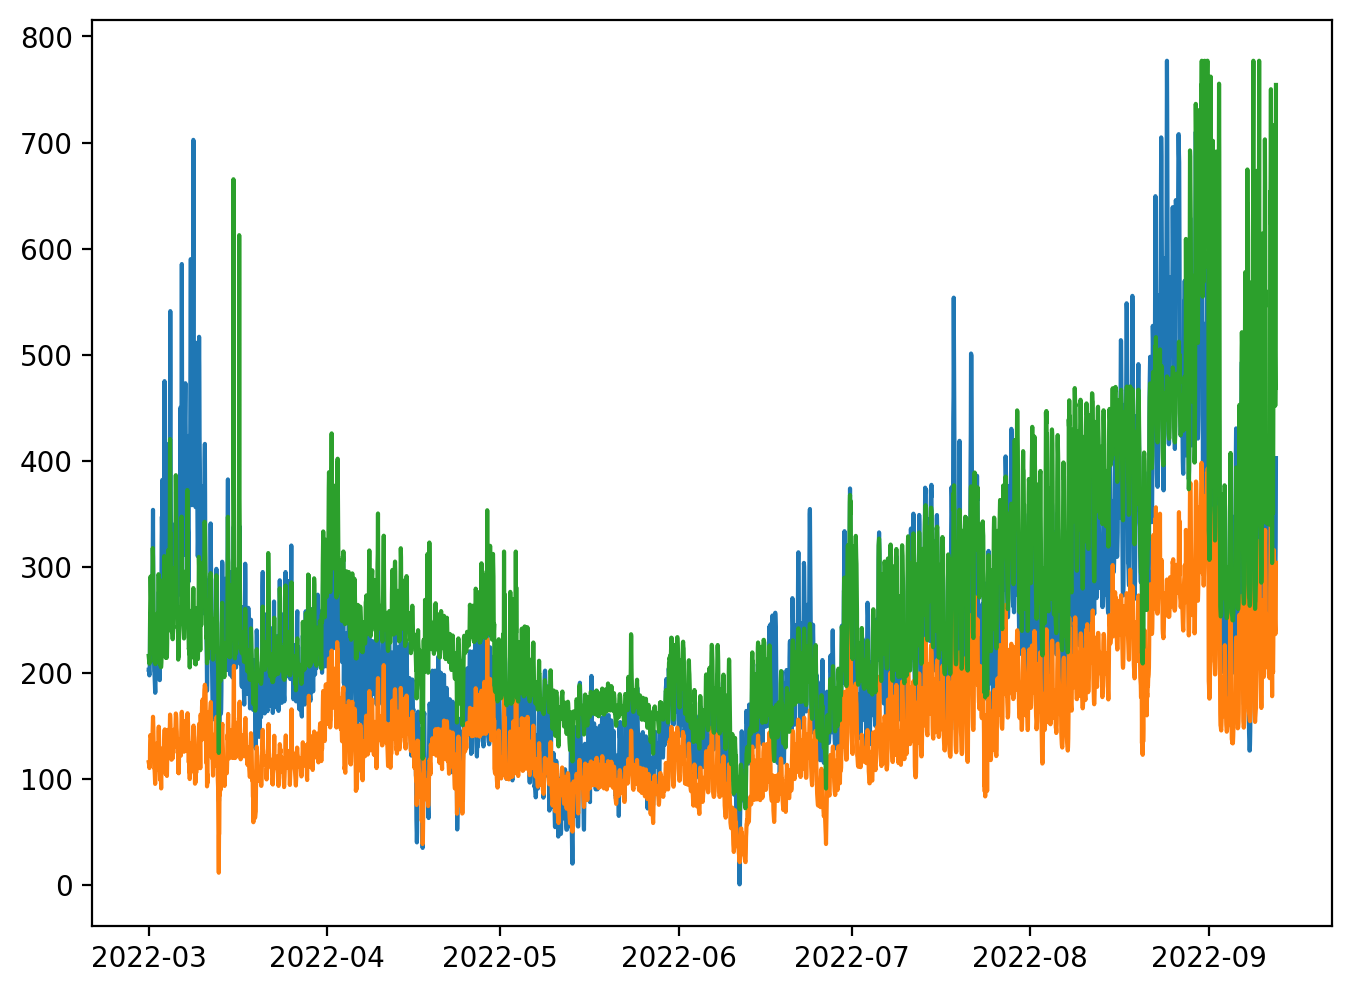

In [21]:
figure(figsize=(8, 6), dpi=200)
plt.plot(test_timestamps, y_test_a1, label='true values')
plt.plot(test_timestamps, lb, label='predicted 0.05 quantile')
plt.plot(test_timestamps, ub, label='predicted 0.95 quantile')


In [32]:
lb = []
ub = []
for i in range(len(auction2_predict)):
    a1 = johnsonsu(*auction2_predict[i,:])
    quantiles = a1.ppf([0.05, 0.95])
    quantiles = np.expand_dims(quantiles, axis=1)
    #scaled_q = scaler_y_a2.inverse_transform(quantiles)
    lb.append(max(quantiles[0], min(y_test_a2)))
    ub.append(min(quantiles[1], max(y_test_a2)))
    

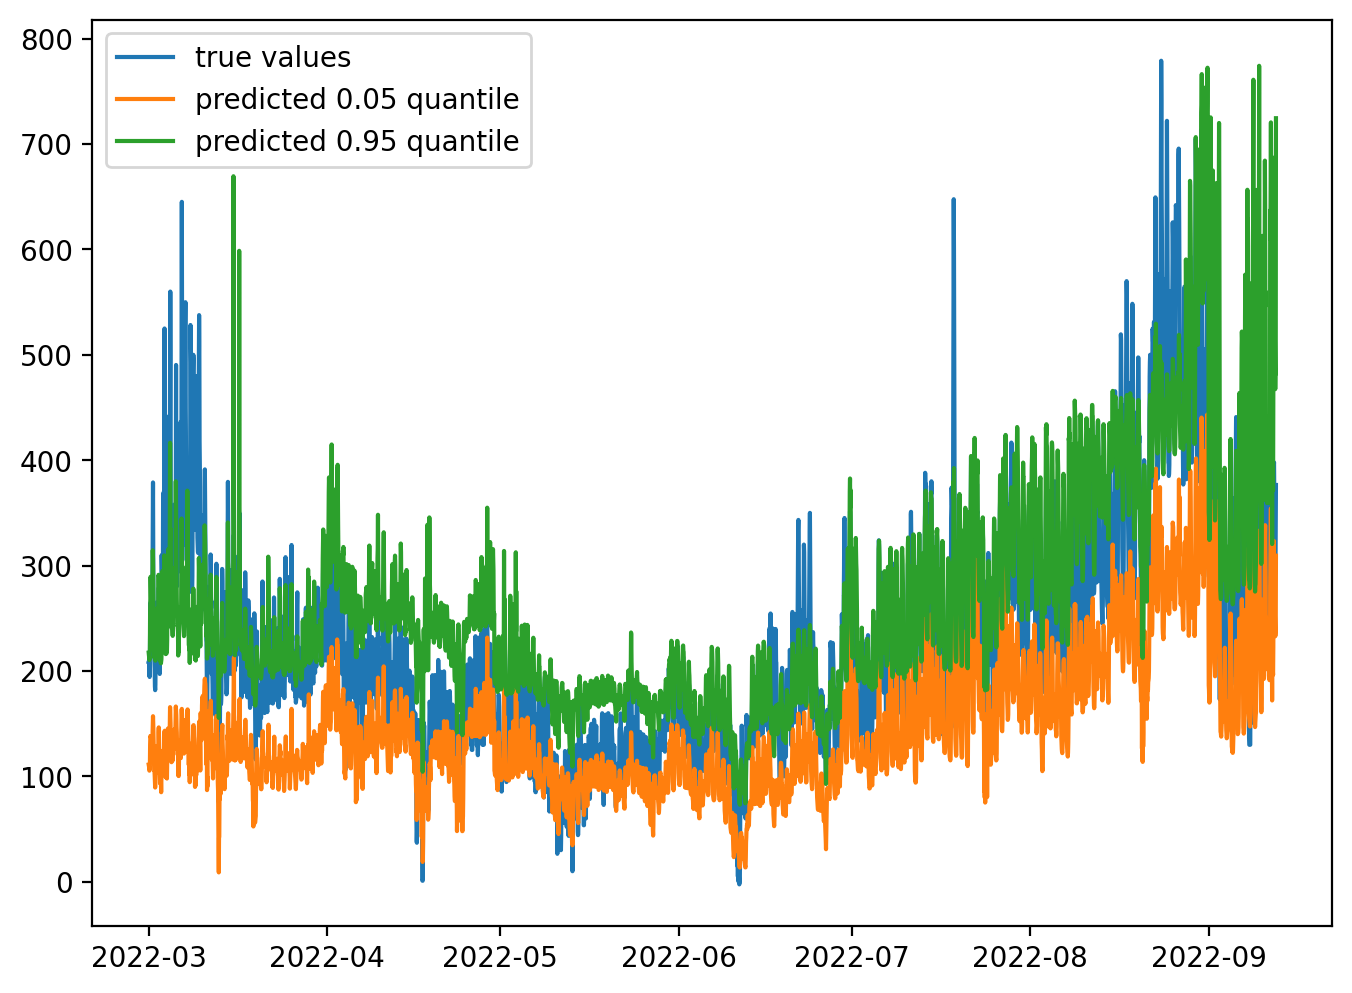

In [33]:
figure(figsize=(8, 6), dpi=200)
plt.plot(test_timestamps, y_test_a2, label='true values')
plt.plot(test_timestamps, lb, label='predicted 0.05 quantile')
plt.plot(test_timestamps, ub, label='predicted 0.95 quantile')
plt.legend(loc="upper left")

In [37]:
lb = []
ub = []
for i in range(len(system_price_predict)):
    a1 = johnsonsu(*system_price_predict[i,:])
    quantiles = a1.ppf([0.05, 0.95])
    quantiles = np.expand_dims(quantiles, axis=1)
    #scaled_q = scaler_y_sp.inverse_transform(quantiles)
    lb.append(max(quantiles[0], min(y_test_sp)))
    ub.append(min(quantiles[1], max(y_test_sp)))


C:\Users\karel\Anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


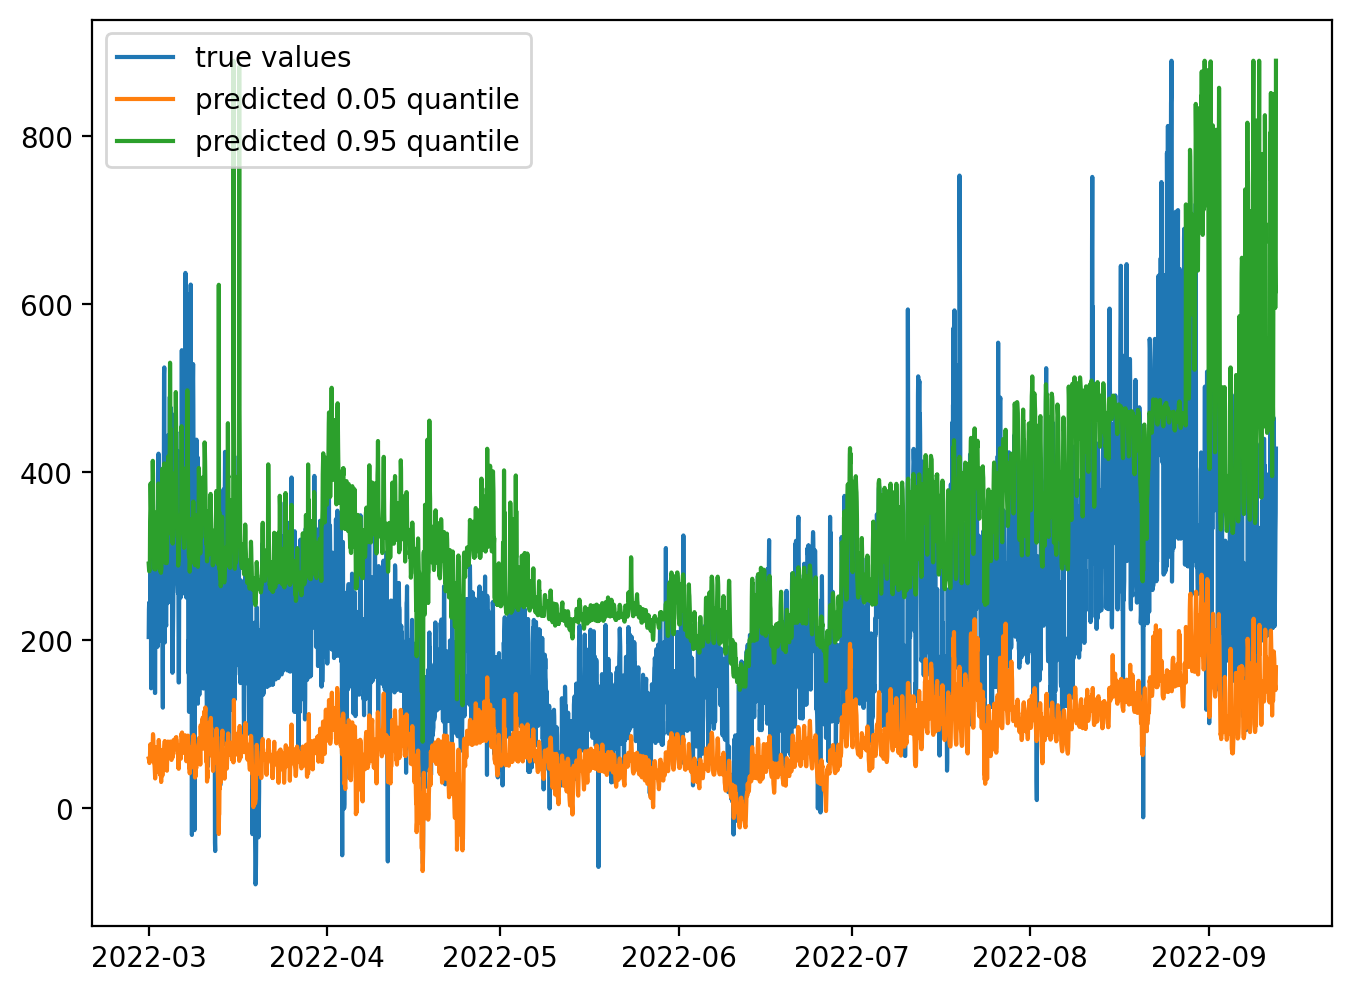

In [38]:
figure(figsize=(8, 6), dpi=200)
plt.plot(test_timestamps, y_test_sp, label='true values')
plt.plot(test_timestamps, lb, label='predicted 0.05 quantile')
plt.plot(test_timestamps, ub, label='predicted 0.95 quantile')
plt.legend(loc="upper left")

## Trading strategy
Function for two possible trading behaviours. The first attempts to buy in auction 1 and sell in auction 2. If auction 1 trade fails, no trade is made. If auction 2 trade fails, system prices are used. The alternative is the exact opposite (sell in auction 1 and buy in auction 2). If a trade occurs, relative and absolute fees are applied. 

In [30]:
def evaluate_bids(bet_1, bet_2, value_a1, value_a2, value_sp, absolute_fee=0, relative_fee=0, sp_punish=0):
    if bet_1 == bet_2:
        return 0
    # we want to buy in the first auction and sell in the second    
    elif bet_1 < bet_2:
        if bet_1 < value_a1:
            return 0
        elif bet_2 <= value_a2:
            return -value_a1 + value_a2 - (value_a1 + value_a2)*relative_fee - absolute_fee
        else:
            return -value_a1 + value_sp - (value_a1 + value_sp)*relative_fee - absolute_fee - sp_punish
    # we want to sell in the first auction and buy in the second one
    elif bet_1 > bet_2:
        if bet_1 > value_a1:
            return 0
        elif bet_2 >= value_a2:
            return value_a1 - value_a2 - (value_a1 + value_a2)*relative_fee - absolute_fee
        else:
            return value_a1 - value_sp - (value_a1 + value_sp)*relative_fee - absolute_fee - sp_punish
        
    

Calculation of optimal betting values with simulated prices given strategy 

In [31]:
# this function is only approximate
def cvar(returns, level=0.95):
    var = np.quantile(returns, 1-level)
    cvar = -returns[returns <= var].mean()
    
    return cvar

# exact formulation
def calculate_CVaR(returns, alpha=0.95):
    n = returns.shape[0]
    
    #variables
    u = pulp.LpVariable.dicts("u",
                                (scenario for scenario in range(n)), lowBound=0)
    ksi = pulp.LpVariable('ksi')

    #model
    model = pulp.LpProblem("CVaR", pulp.LpMinimize)

    #objective function
    model += ksi + 1/((1-alpha)*n) *pulp.lpSum( [u[scenario] for scenario in range(n) ]), "CVaR"
    #constraints
    for scenario in range(n):
        model += u[scenario] >= -returns[scenario] - ksi

    model.solve()
    if model.status != 1:
        ret = np.nan
    else:
        ret = model.objective.value()
    return ret

    

In [ ]:
num_of_bet_points = 41
bet_range=(0,600)
relative_fee = 0
absolute_fee = 0
sp_punish = 0
lambd = 0.3

bets_dict = {}
rets_dict = {}

strategies = ['mean', 'median', 'prob', 'mean-cvar']

for strategy in strategies:
    bets_dict[strategy] = []
    rets_dict[strategy] = []
    
    
for i in range(len(simulation_a1)):
    if i%100==0:
        print(i)
    
    bet_opt = {}
    for strategy in strategies:
        bet_opt[strategy] = [-10000, -10000]
    
    ret_max = {
          'mean' : 0.0
        , 'median': 0.0
        , 'cvar' : -1000.0
        , 'mean-cvar' : -1000000000.0
        , 'prob' : 0.0
    }
    
    expanded_sim_a1 = np.reshape(np.repeat(simulation_a1[i,:], repeats=num_of_bet_points), (sample_size, num_of_bet_points))
    expanded_sim_a2 = np.reshape(np.repeat(simulation_a2[i,:], repeats=num_of_bet_points), (sample_size, num_of_bet_points))
    expanded_sim_sp = np.reshape(np.repeat(simulation_sp[i,:], repeats=num_of_bet_points), (sample_size, num_of_bet_points))
    
    for bet_1 in np.linspace(bet_range[0], bet_range[1], num_of_bet_points):
        
        expanded_bet_1 = np.repeat(bet_1, num_of_bet_points)
        expanded_bet_2 = np.linspace(bet_range[0], bet_range[1], num_of_bet_points)
        
        expanded_bet_1 = np.reshape(np.repeat(expanded_bet_1, repeats=sample_size), (sample_size, num_of_bet_points))
        expanded_bet_2 = np.reshape(np.repeat(expanded_bet_2, repeats=sample_size), (sample_size, num_of_bet_points), order='F')
        
        # we want to buy in the first auction and sell in the second  
        not_first_trade = expanded_bet_1 < expanded_sim_a1
        second_trade = expanded_bet_2 <= expanded_sim_a2

        second_trade_return = -expanded_sim_a1 + expanded_sim_a2 - (expanded_sim_a1 + expanded_sim_a2)*relative_fee - absolute_fee
        not_second_trade_return = -expanded_sim_a1 + expanded_sim_sp - (expanded_sim_a1 + expanded_sim_sp)*relative_fee - absolute_fee - sp_punish

        returns_buy_sell = (1-not_first_trade) * (second_trade*(second_trade_return) + (1-second_trade)*not_second_trade_return)

        
        # we want to sell in the first auction and buy in the second one
        not_first_trade = expanded_bet_1 > expanded_sim_a1
        second_trade = expanded_bet_2 >= expanded_sim_a2

        second_trade_return = expanded_sim_a1 - expanded_sim_a2 - (expanded_sim_a1 + expanded_sim_a2)*relative_fee - absolute_fee
        not_second_trade_return = expanded_sim_a1 - expanded_sim_sp - (expanded_sim_a1 + expanded_sim_sp)*relative_fee - absolute_fee - sp_punish

        returns_sell_buy = (1-not_first_trade) * (second_trade*(second_trade_return) + (1-second_trade)*not_second_trade_return)
        
        
        # compute the mean, median and CVaR
        aggregate_buy_sell = {}
        aggregate_sell_buy = {}
        
        aggregate_buy_sell['mean'] = returns_buy_sell.mean(axis=0)
        aggregate_sell_buy['mean'] = returns_sell_buy.mean(axis=0)
        
        aggregate_buy_sell['median'] = np.median(returns_buy_sell, axis=0)
        aggregate_sell_buy['median'] = np.median(returns_sell_buy, axis=0)
        
        aggregate_buy_sell['cvar'] = -np.apply_along_axis(cvar, 0, returns_buy_sell)    
        aggregate_sell_buy['cvar'] = -np.apply_along_axis(cvar, 0, returns_sell_buy)  
        
        aggregate_buy_sell['prob'] = (returns_buy_sell > 0).sum(axis=0)/sample_size    
        aggregate_sell_buy['prob'] = (returns_sell_buy > 0).sum(axis=0)/sample_size 
        
        aggregate_buy_sell['mean-cvar'] = aggregate_buy_sell['mean'] + lambd * aggregate_buy_sell['cvar']  
        aggregate_sell_buy['mean-cvar'] = aggregate_sell_buy['mean'] + lambd * aggregate_sell_buy['cvar']
        
        
        # decide whenther use sell buy or buy sell
        aggregate = {}
        for strategy in strategies:
            aggregate[strategy] = np.where(bet_1 < np.linspace(bet_range[0], bet_range[1], num_of_bet_points), aggregate_buy_sell[strategy], aggregate_sell_buy[strategy])

        # take the best bet_2
        max_agreggrate = {}
        max_agreggrate_index = {}
        for strategy in strategies:
            max_agreggrate[strategy] = aggregate[strategy].max()
            max_agreggrate_index[strategy] = aggregate[strategy].argmax()

        # get optimal bet_2
        optimal_bet_2 = {}
        for strategy in strategies:
            optimal_bet_2[strategy] = expanded_bet_2[0,max_agreggrate_index[strategy]]
        
        for strategy in strategies:
            if max_agreggrate[strategy] > ret_max[strategy]:
                bet_opt[strategy] = [bet_1,optimal_bet_2[strategy]]
                ret_max[strategy] = max_agreggrate[strategy]
    
    for strategy in strategies:
        bets_dict[strategy].append(bet_opt[strategy])
        rets_dict[strategy].append(ret_max[strategy])

In [33]:
# # save computed bets and returns

pickle_obj = [bets_dict, rets_dict]

pickle.dump(pickle_obj, open(path+"/optimized_bids_FF.pkl", "wb"))


## Results analysis

In [34]:
# load previously saved results

strategies = ['mean', 'median', 'prob', 'mean-cvar']

bets_dict, rets_dict = pickle.load(open(path+"/optimized_bids_FF.pkl", "rb"))

<BarContainer object of 4696 artists>

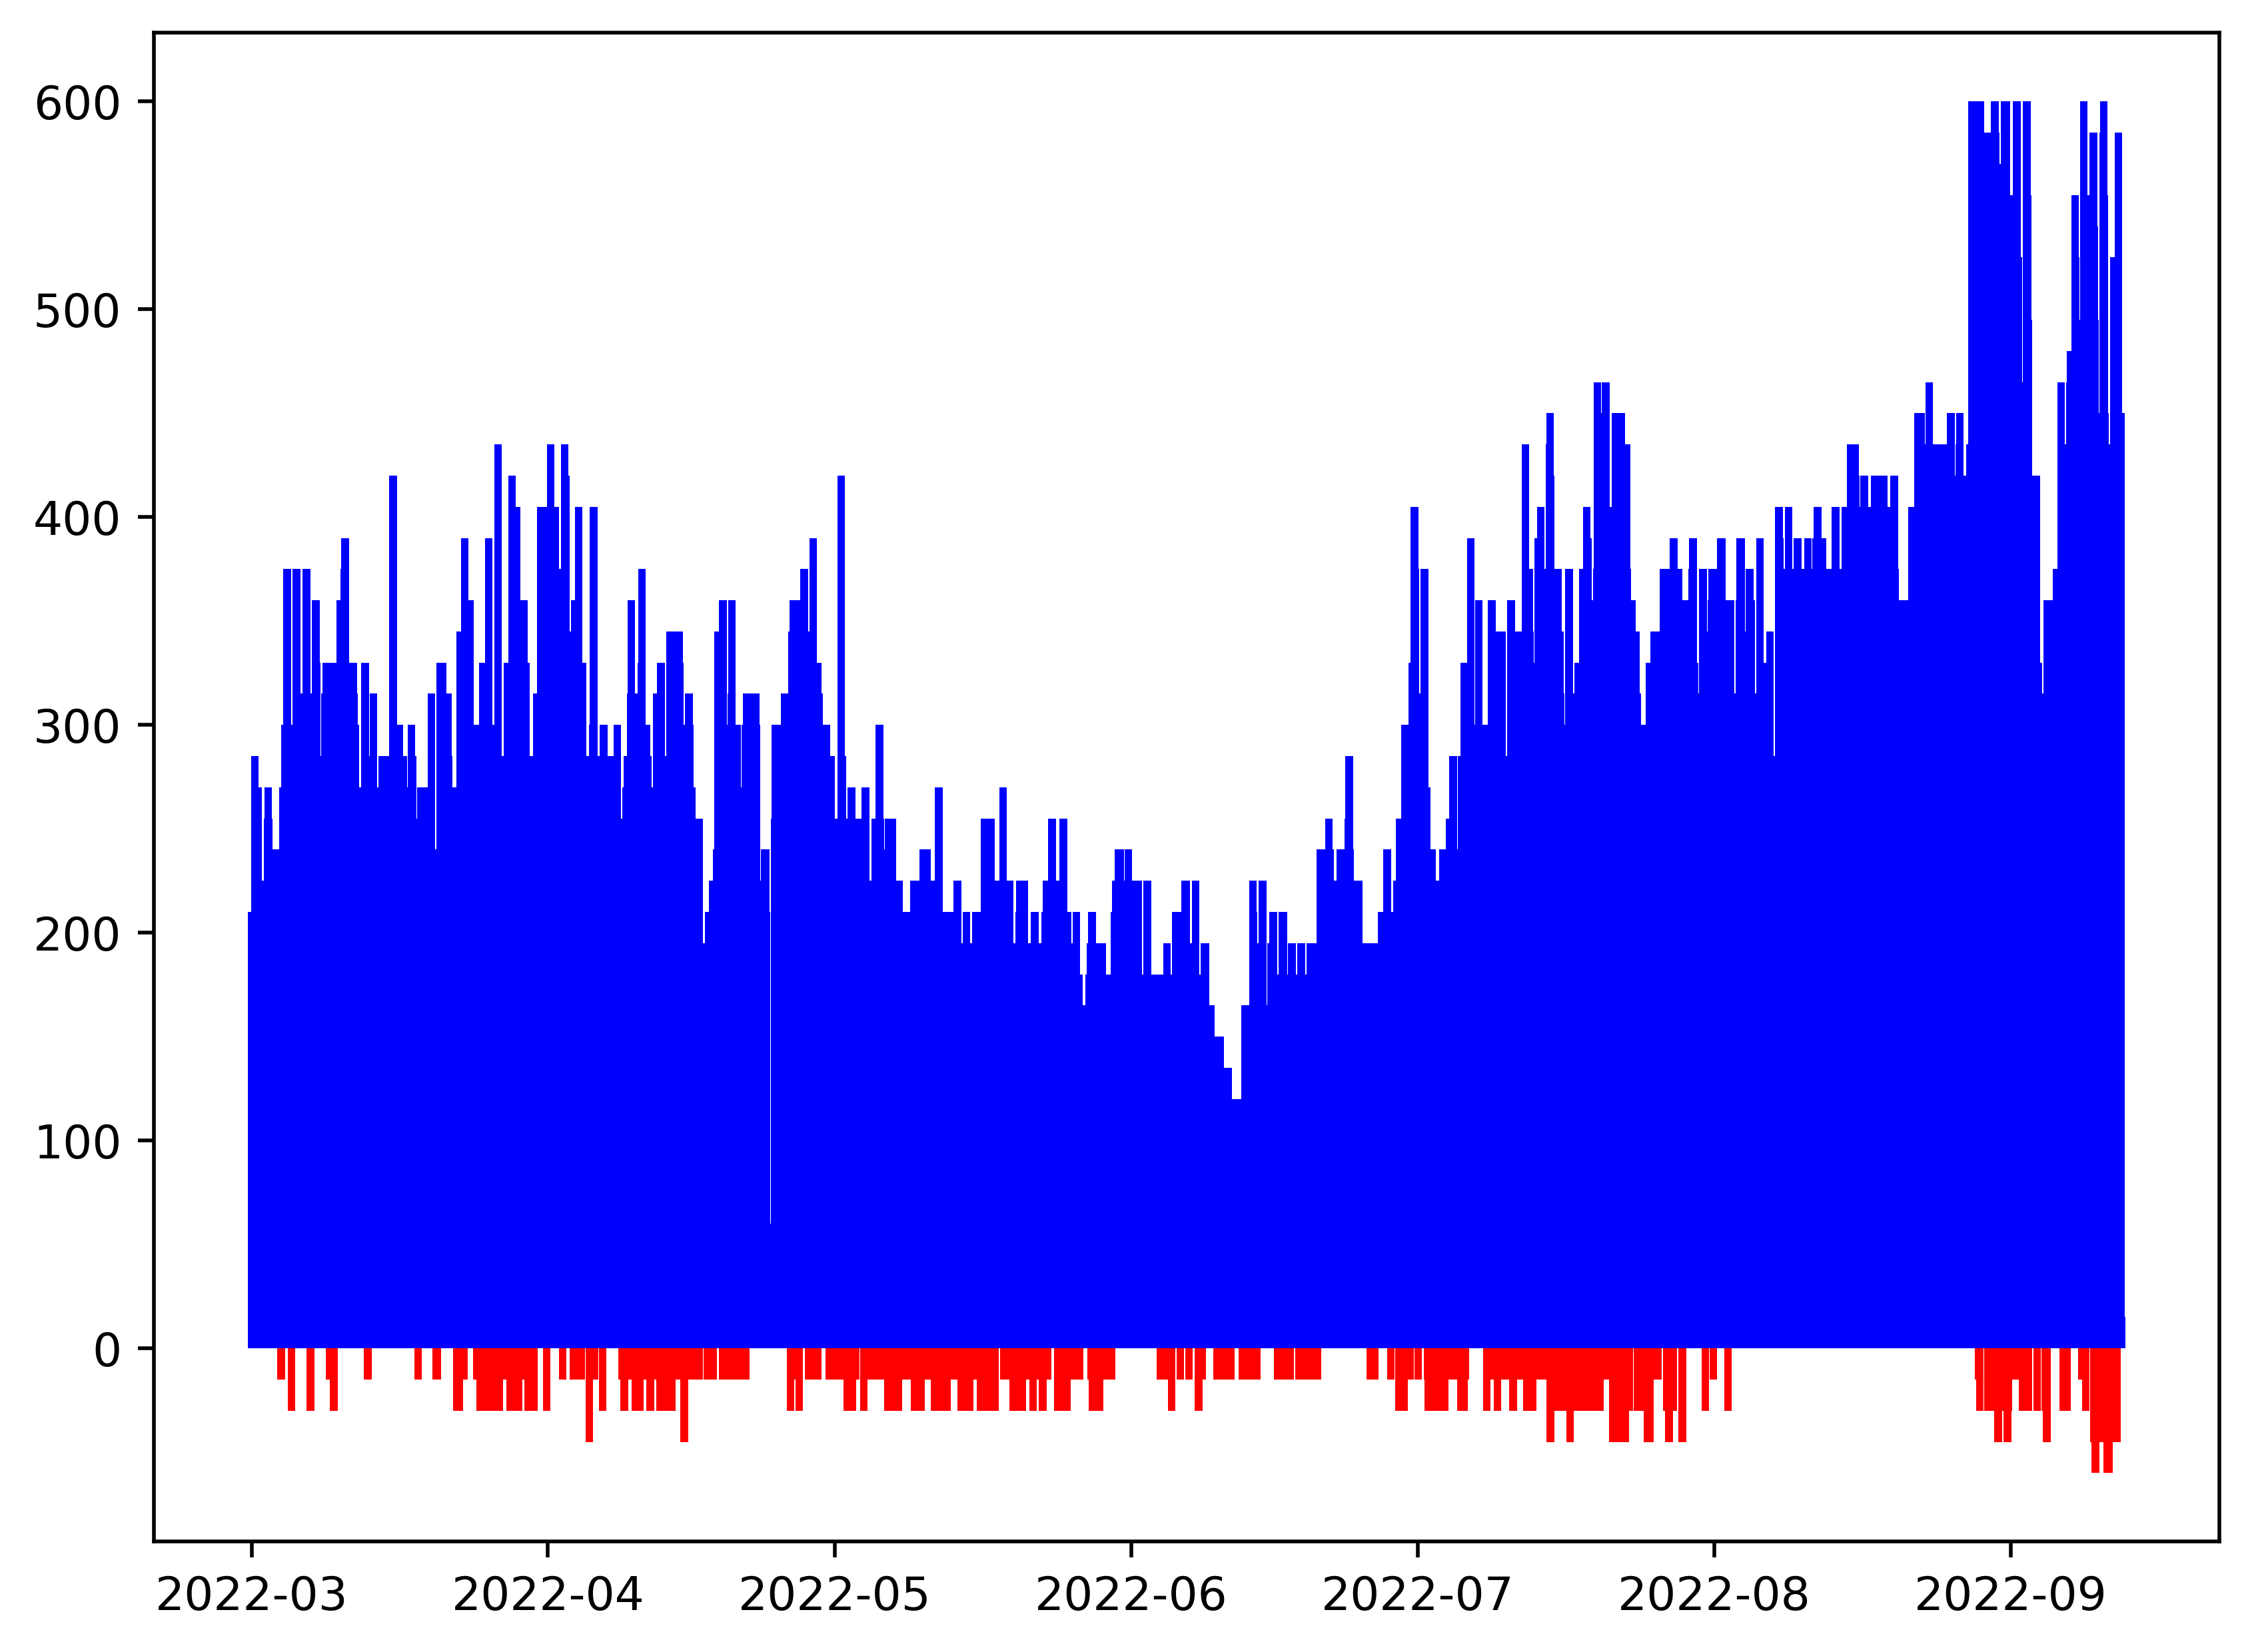

In [36]:
figure(figsize=(8, 6), dpi=500)

strategy='mean-cvar'
auctions_difference = np.array(bets_dict[strategy])[:, 0] -  np.array(bets_dict[strategy])[:, 1]
colors = np.where(auctions_difference>0, 'b', 'r')
plt.bar(test_timestamps, auctions_difference, color=colors, label=strategy)

# plt.savefig(r'C:\Users\karel\OneDrive\Škola\Matfyz\Doktorát\staz_berlin\energy_trading_prezentation\mean_cvar_bids.png', transparent=True)

<BarContainer object of 4696 artists>

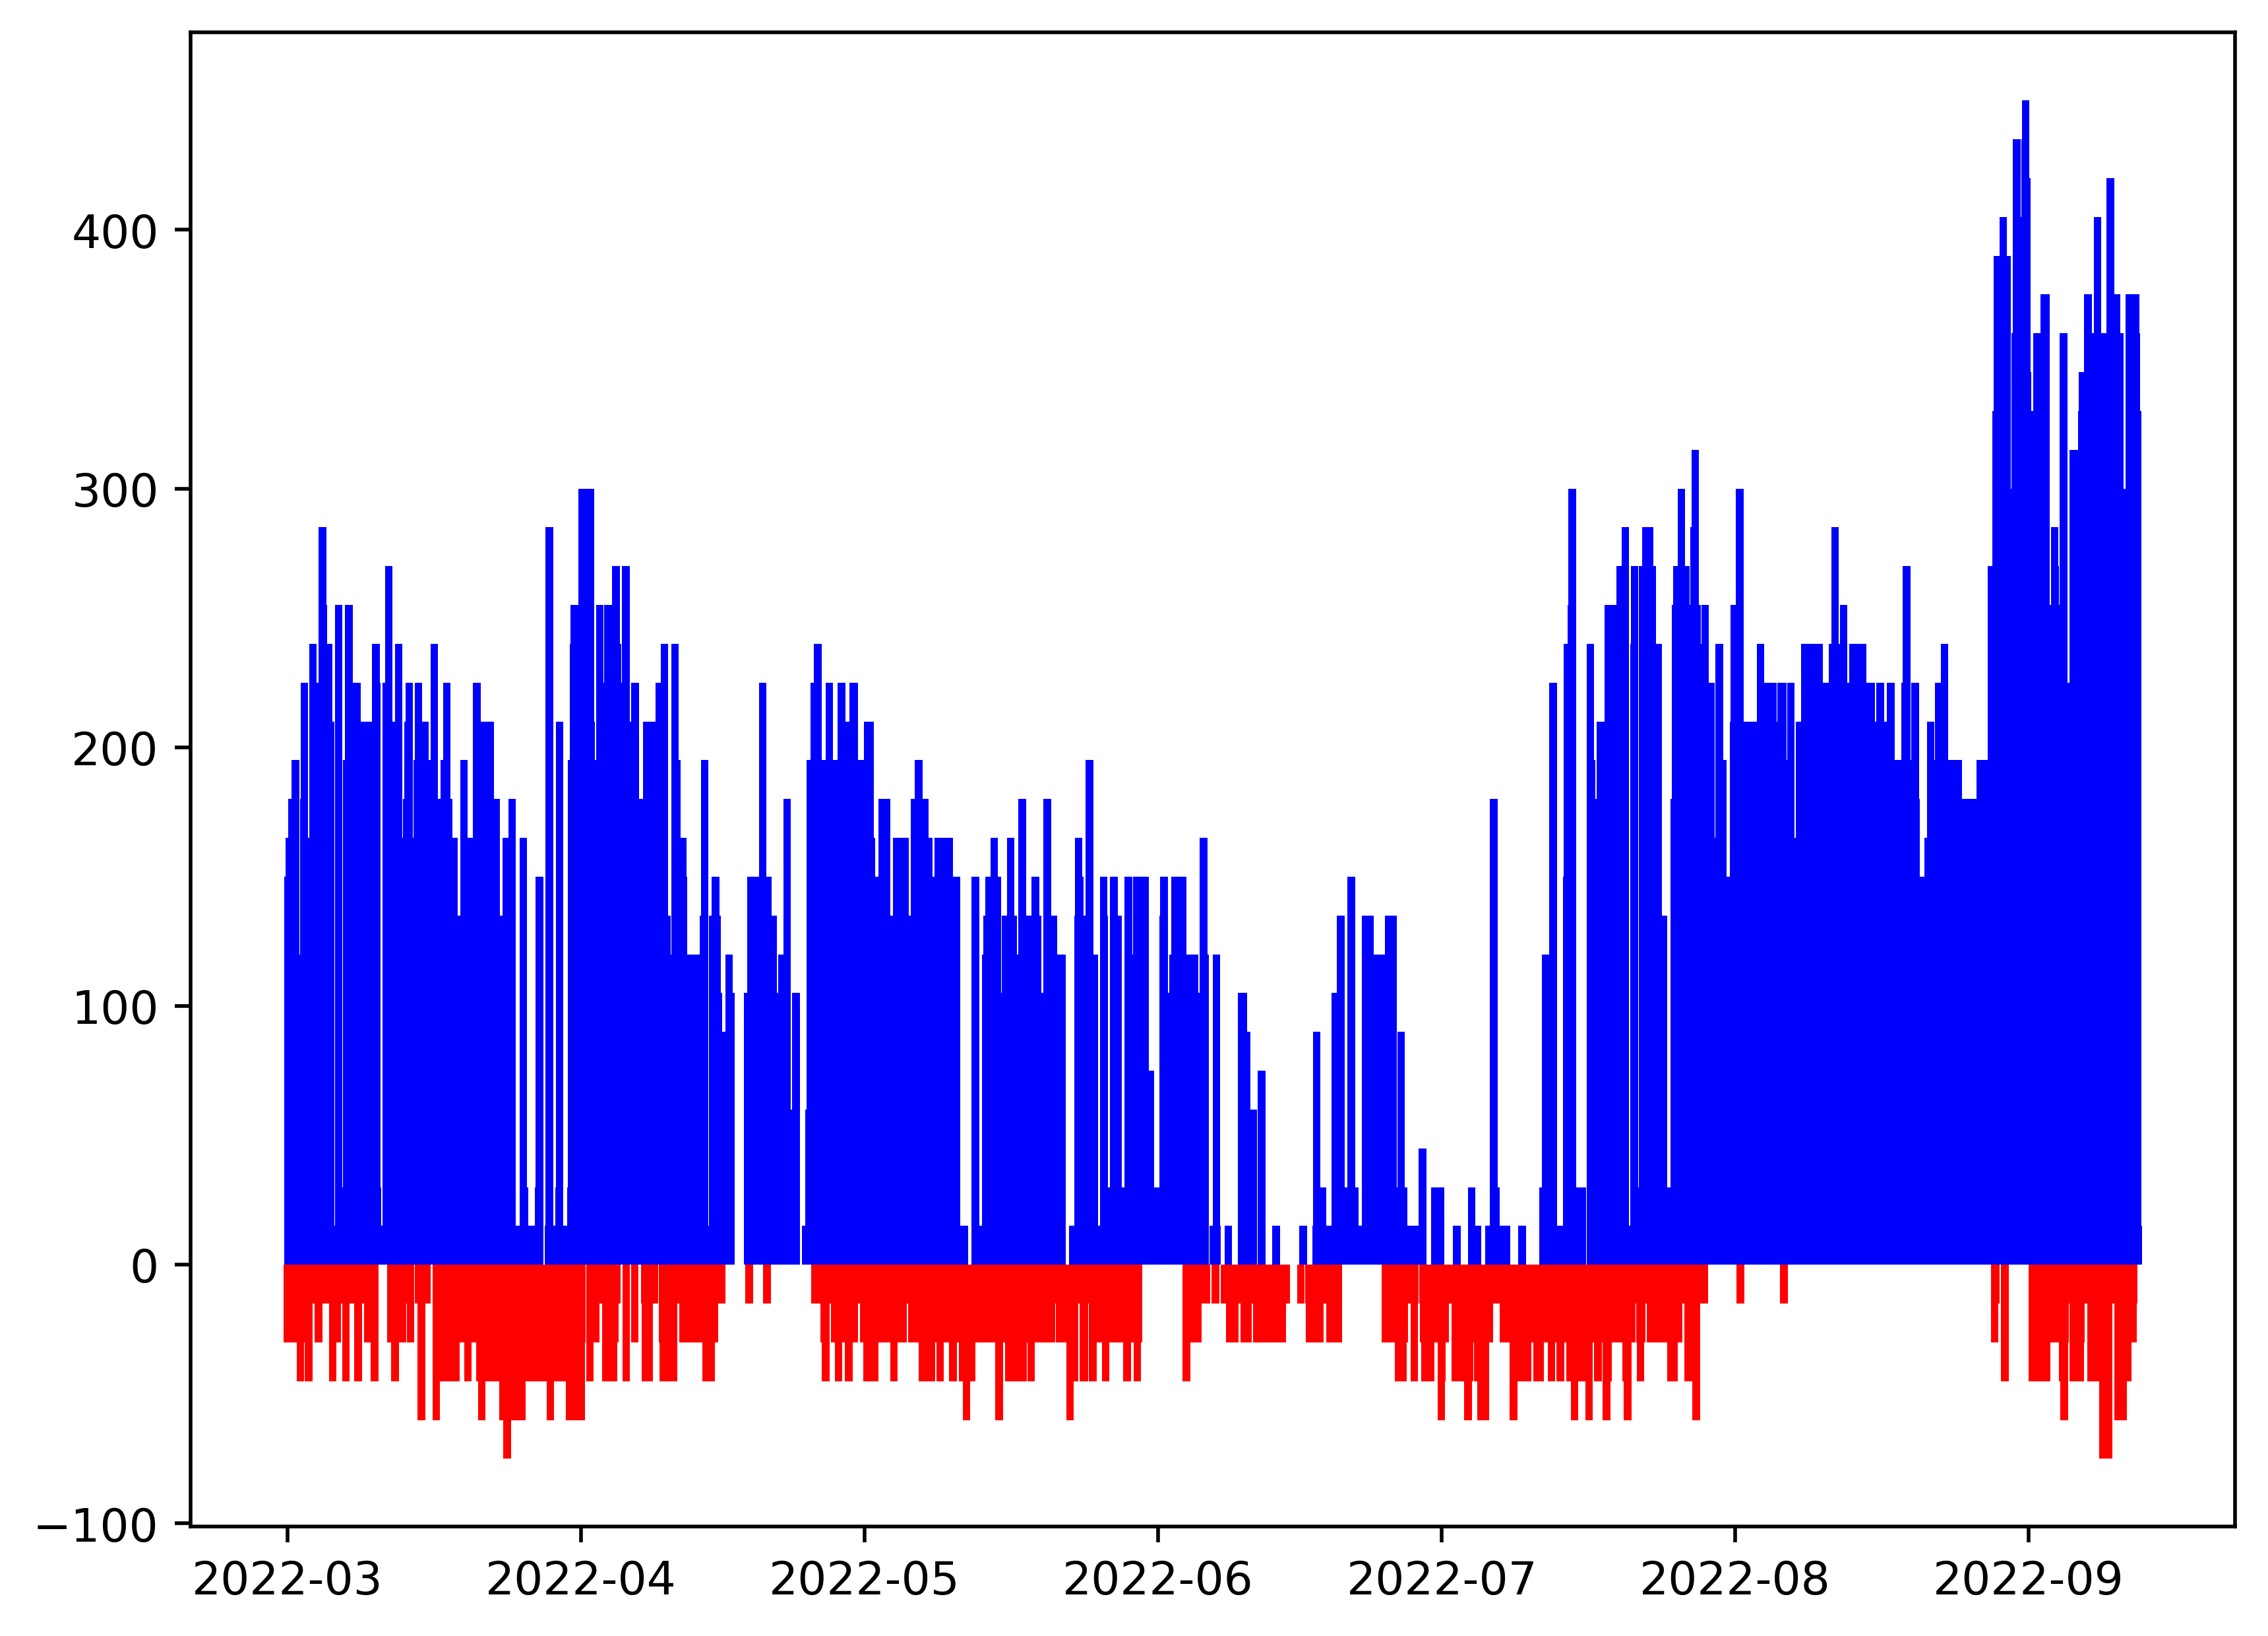

In [37]:
figure(figsize=(8, 6), dpi=500)

strategy='mean'
auctions_difference = np.array(bets_dict[strategy])[:, 0] -  np.array(bets_dict[strategy])[:, 1]
colors = np.where(auctions_difference>0, 'b', 'r')
plt.bar(test_timestamps, auctions_difference, color=colors, label=strategy)

# plt.savefig(r'C:\Users\karel\OneDrive\Škola\Matfyz\Doktorát\staz_berlin\energy_trading_prezentation\mean_bids.png', transparent=True)

Backtesting for strategy with performace metrics

In [38]:
ret_backtest = {}
ret_backtest_total = {}
for strategy in strategies:
    ret_backtest[strategy]=np.array([])
    
for i in range(len(bets_dict['median'])):
    for strategy in strategies:
        ret_backtest[strategy]=np.append(ret_backtest[strategy], evaluate_bids(bets_dict[strategy][i][0], bets_dict[strategy][i][1], 
                                                 y_test_a1[i], y_test_a2[i], y_test_sp[i], absolute_fee=0.005))


for strategy in strategies:
    
    ret_backtest[strategy]=np.nan_to_num(ret_backtest[strategy])
    ret_backtest_total[strategy]=ret_backtest[strategy].sum()
    
    print(f"Using strategy {strategy} we achieved total return:")
    print(ret_backtest_total[strategy])

Using strategy mean we achieved total return:
22321.320000000007
Using strategy median we achieved total return:
-2874.4349999999995
Using strategy prob we achieved total return:
-3307.8449999999993
Using strategy mean-cvar we achieved total return:
18031.605000000003


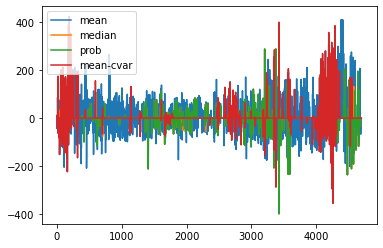

In [39]:
for strategy in strategies:
    plt.plot(ret_backtest[strategy], label=strategy)
    
plt.legend(loc="upper left")

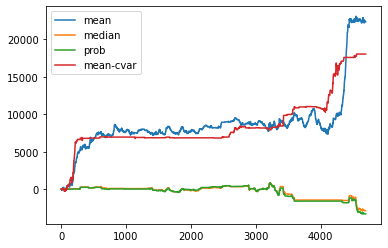

In [40]:
for strategy in strategies:
    plt.plot(np.cumsum(ret_backtest[strategy]), label=strategy)
    
plt.legend(loc="upper left")

In [42]:
# calculate maximum drop
max_drop = {}
max_drop_relative = {}
for strategy in strategies:
    running_sum = np.cumsum(ret_backtest[strategy])
    running_max = np.maximum.accumulate(running_sum)
    drop = running_sum - running_max
    max_drop[strategy] = drop.min()
    max_drop_relative[strategy] = max_drop[strategy]/running_sum[-1]

In [43]:
max_drop

{'mean': -3418.7749999999833,
 'median': -3728.010000000001,
 'prob': -4133.4800000000005,
 'mean-cvar': -1611.0350000000017}

In [44]:
max_drop_relative

{'mean': -0.15316186497931011,
 'median': 1.2969540100924182,
 'prob': 1.2495990592062203,
 'mean-cvar': -0.08934506939343456}

In [75]:
df = pd.DataFrame(index=strategies,  columns=['mean_return', 'variance', 'Sharpe'])

In [77]:
for strategy in strategies:
    relative_returns = results_history[strategy]/invested_history[strategy]
    df.loc[strategy, 'mean_return'] = np.mean(relative_returns)
    df.loc[strategy, 'variance'] = np.var(relative_returns)
    df.loc[strategy, 'Sharpe'] = df.loc[strategy, 'mean_return'] / df.loc[strategy, 'variance']


In [78]:
df

,mean_return,variance,Sharpe
mean,0.000334,0.00195,0.171267
median,-0.000647,0.003143,-0.205875
prob,-0.001013,0.002969,-0.341044
mean-cvar,0.012648,0.01905,0.663966
